# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata

In [2]:
(movies,people,list_of_genres_id) = ldata.load_dataframes();

2019-01-10 11:31:36,112 | INFO : Data loaded !


In [3]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

2019-01-10 11:31:36,248 | INFO : The budget max = 31115000
2019-01-10 11:31:36,250 | INFO : 862      2000000
1125    31115000
2140    20000000
2170      806948
2192    20000000
Name: budget, dtype: int64
2019-01-10 11:31:36,261 | INFO : The number of nodes is : 63


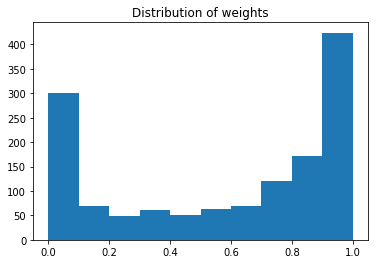

2019-01-10 11:31:36,423 | INFO : The number of edges is : 519
2019-01-10 11:31:36,424 | INFO : Adjacency done !
2019-01-10 11:31:36,436 | INFO : The budget max = 55000000
2019-01-10 11:31:36,438 | INFO : 813     55000000
1243      500000
1367    35000000
1403    35000000
1510    35000000
Name: budget, dtype: int64
2019-01-10 11:31:36,449 | INFO : The number of nodes is : 89


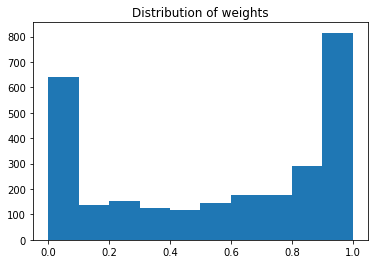

2019-01-10 11:31:36,601 | INFO : The number of edges is : 993
2019-01-10 11:31:36,602 | INFO : Adjacency done !
2019-01-10 11:31:36,613 | INFO : The budget max = 70000000
2019-01-10 11:31:36,617 | INFO : 379    20000000
417     8000000
587    70000000
655     4200000
794    63000000
Name: budget, dtype: int64
2019-01-10 11:31:36,628 | INFO : The number of nodes is : 232


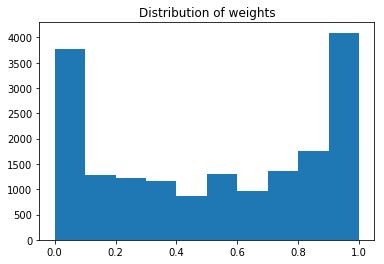

2019-01-10 11:31:36,780 | INFO : The number of edges is : 5005
2019-01-10 11:31:36,781 | INFO : Adjacency done !
2019-01-10 11:31:36,804 | INFO : The budget max = 200000000
2019-01-10 11:31:36,808 | INFO : 25     200000000
70     170000000
75     175000000
149    140000000
164    140000000
Name: budget, dtype: int64
2019-01-10 11:31:36,822 | INFO : The number of nodes is : 622


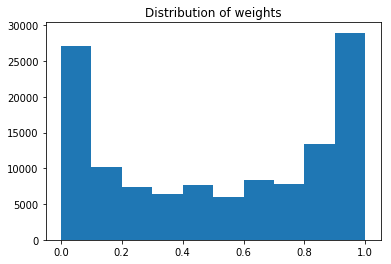

2019-01-10 11:31:36,987 | INFO : The number of edges is : 37657
2019-01-10 11:31:36,988 | INFO : Adjacency done !
2019-01-10 11:31:37,106 | INFO : The budget max = 300000000
2019-01-10 11:31:37,107 | INFO : 0     237000000
1     300000000
5     258000000
8     250000000
10    270000000
Name: budget, dtype: int64
2019-01-10 11:31:37,124 | INFO : The number of nodes is : 1554


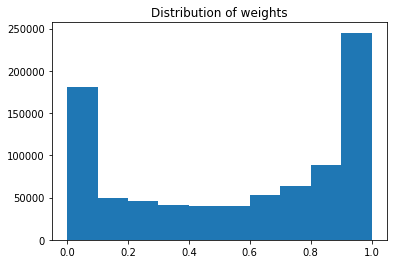

2019-01-10 11:31:37,394 | INFO : The number of edges is : 297204
2019-01-10 11:31:37,394 | INFO : Adjacency done !
2019-01-10 11:31:38,595 | INFO : The budget max = 380000000
2019-01-10 11:31:38,596 | INFO : 2    245000000
3    250000000
4    260000000
6    260000000
7    280000000
Name: budget, dtype: int64
2019-01-10 11:31:38,614 | INFO : The number of nodes is : 1139


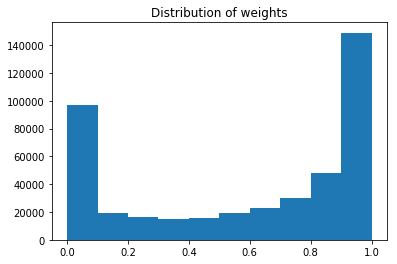

2019-01-10 11:31:38,809 | INFO : The number of edges is : 174285
2019-01-10 11:31:38,810 | INFO : Adjacency done !


In [4]:
#(adjacency, movies_by_budget) = ldata.make_budget_based_adjacency(movies);

adjacenciesFilteredByYears = []
moviesByBudgetFilteredByYears = []
genreOfMoviesFilteredByYears=[]
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget,genreOfMovies) = ldata.make_budget_based_adjacency(moviesData,list_of_genres_id);
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    genreOfMoviesFilteredByYears.append(genreOfMovies)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))



In [5]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

In [6]:
i = 0
GCgraphsFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #creations des coordonées des giant component
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    adjacency= nx.to_numpy_array(Gc)
    GCgraphsFilteredByYears.append(Gc)
    CoordsSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    
    i = i+1

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


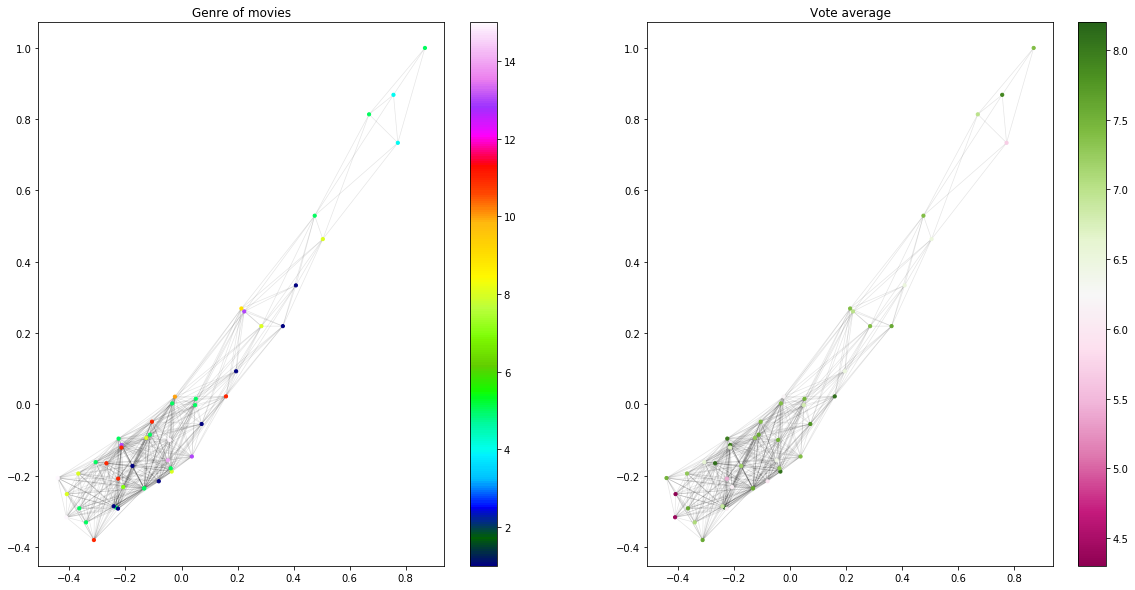

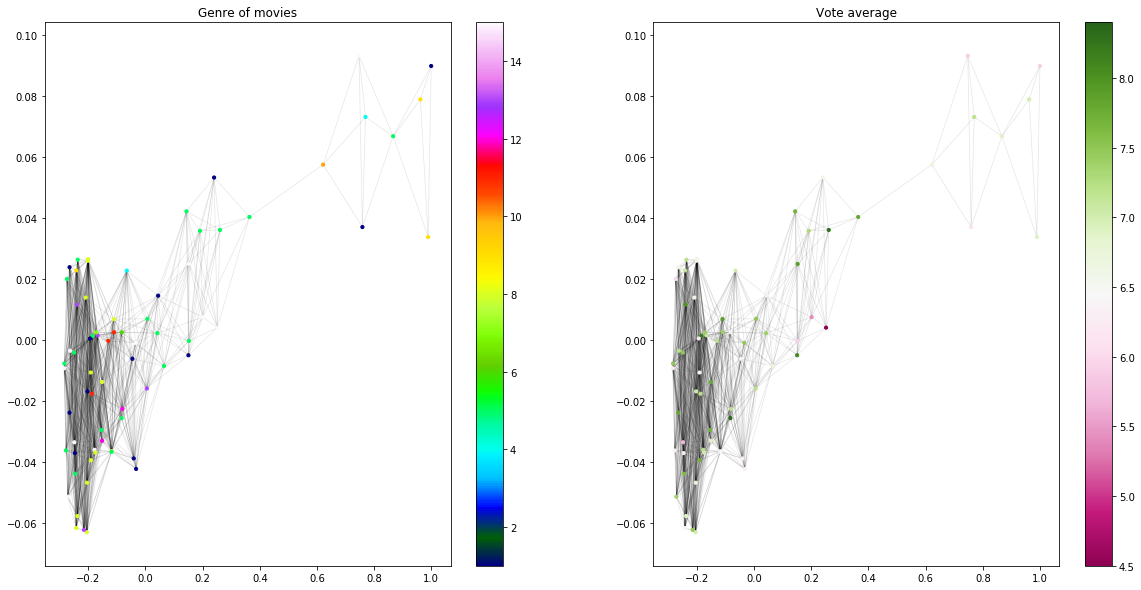

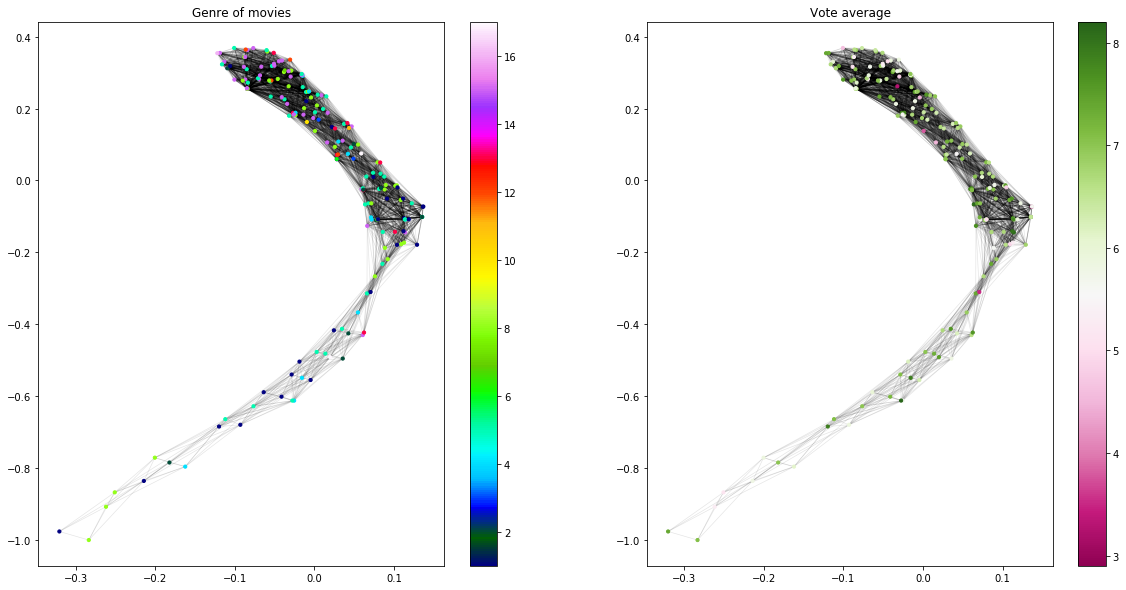

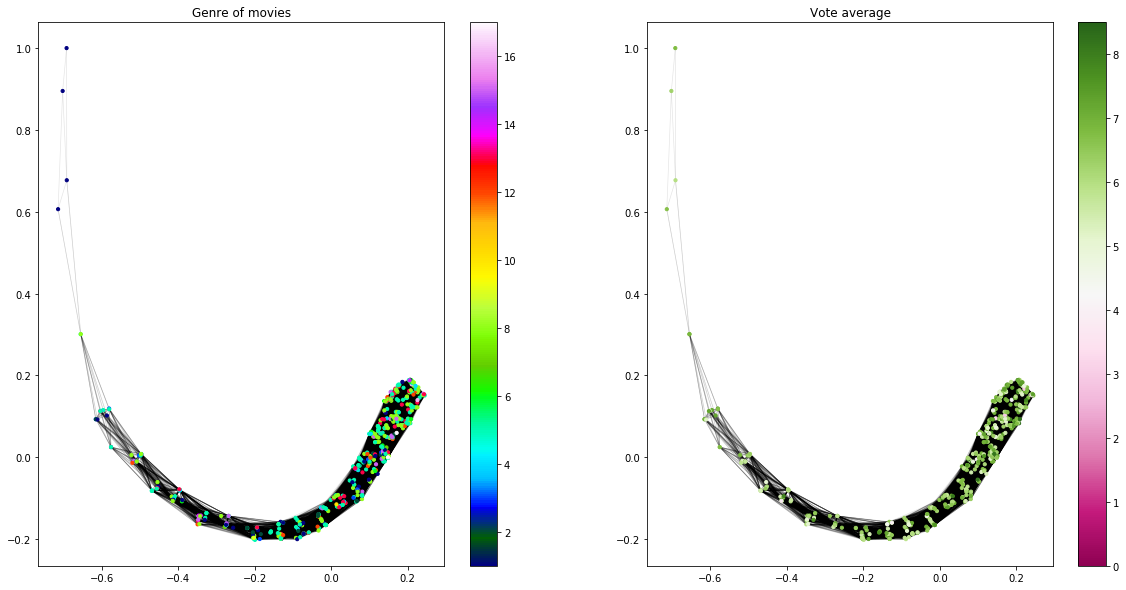

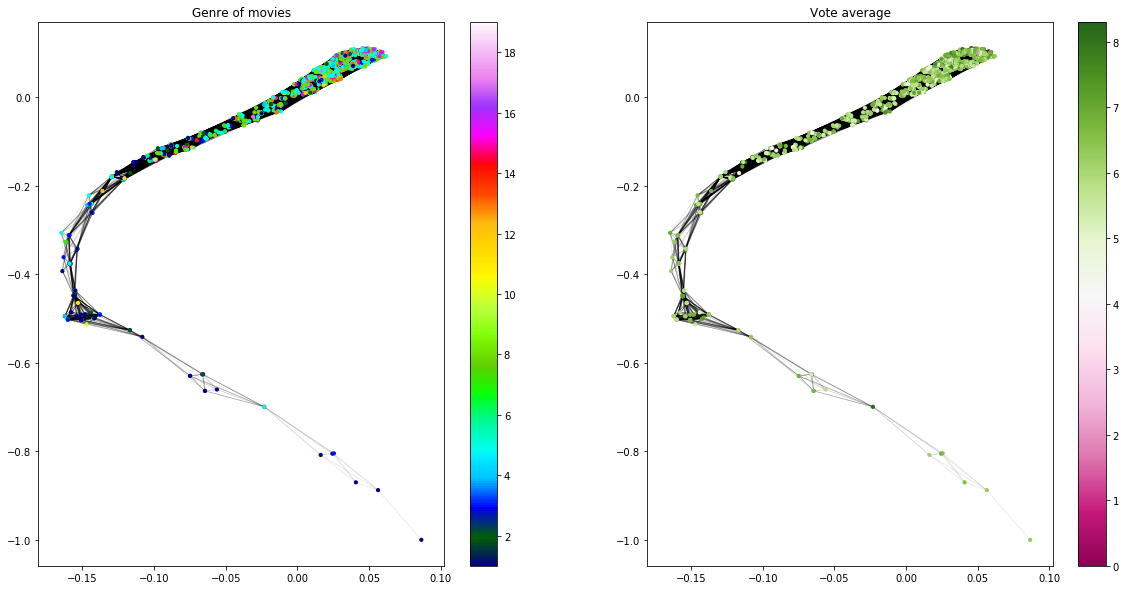

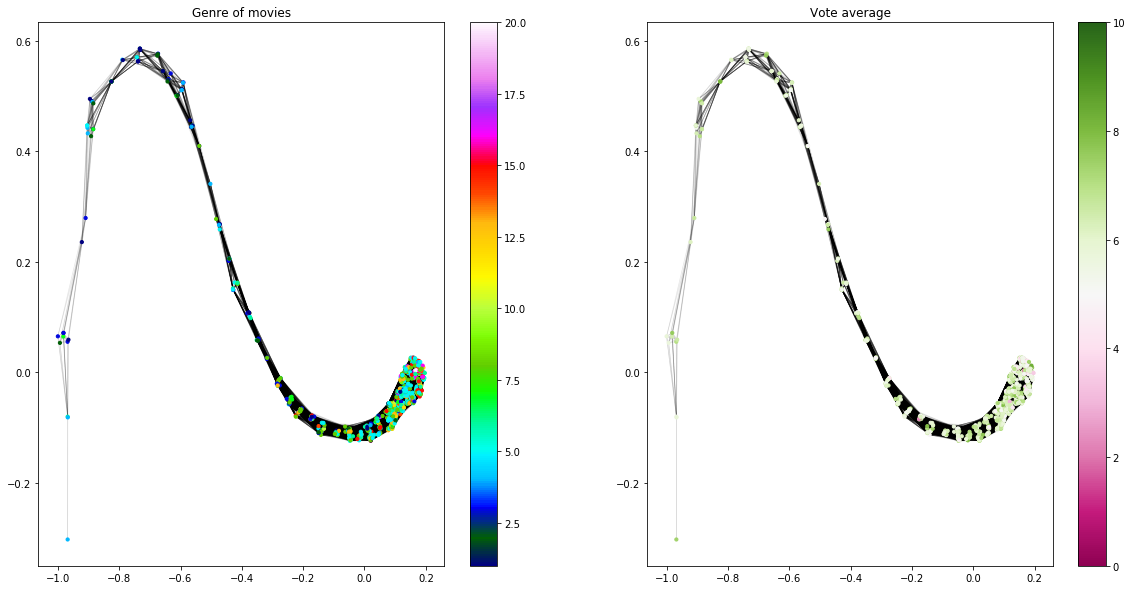

In [7]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    labels = genreOfMoviesFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='gist_ncar')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = voteAvrgFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1
    

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


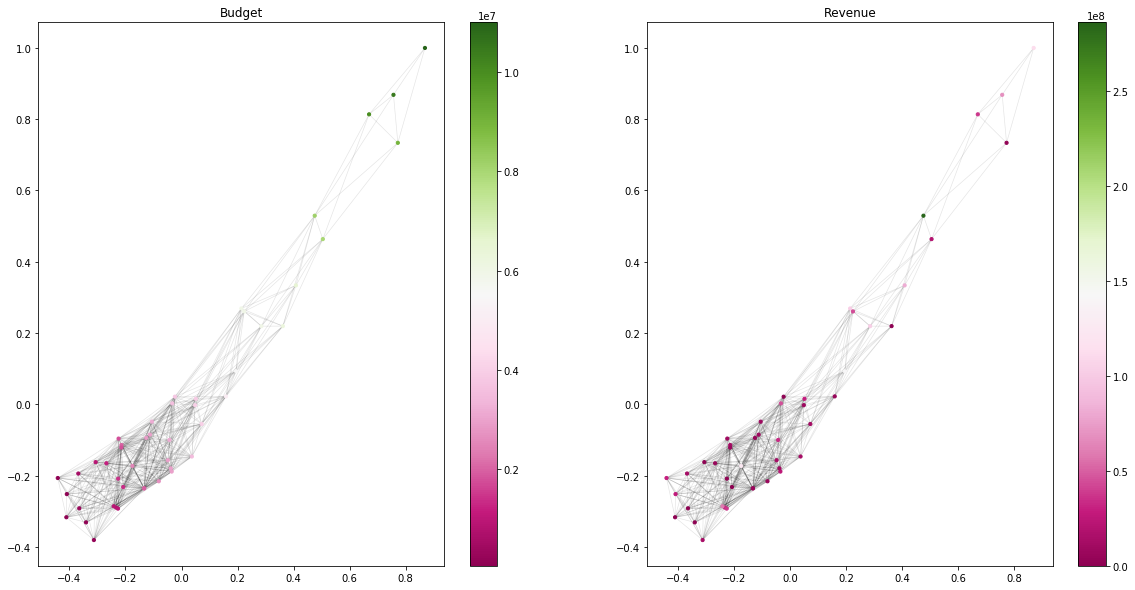

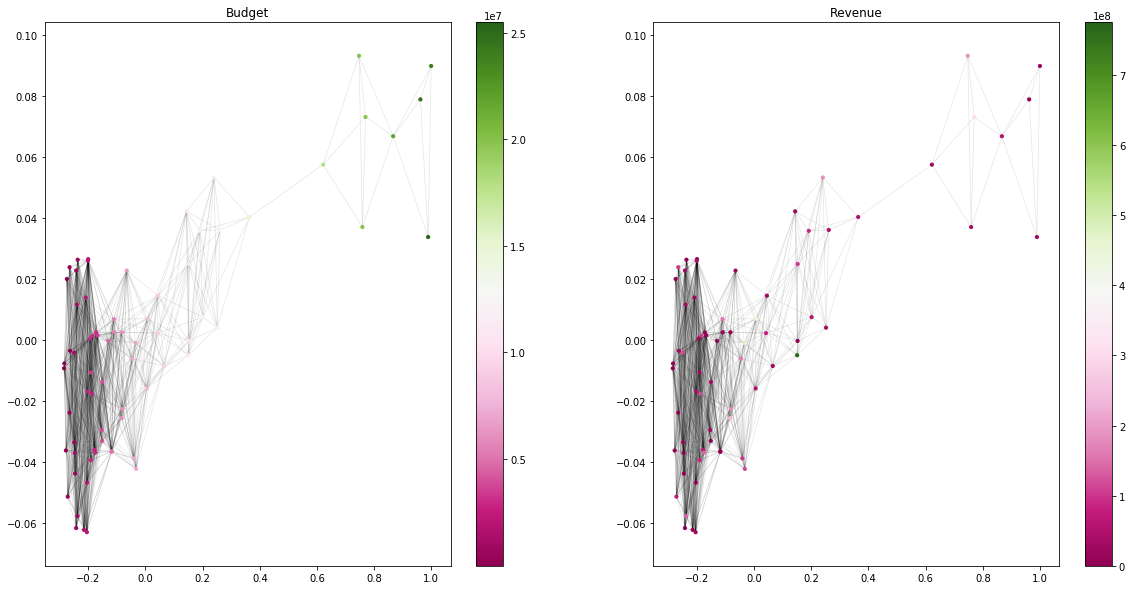

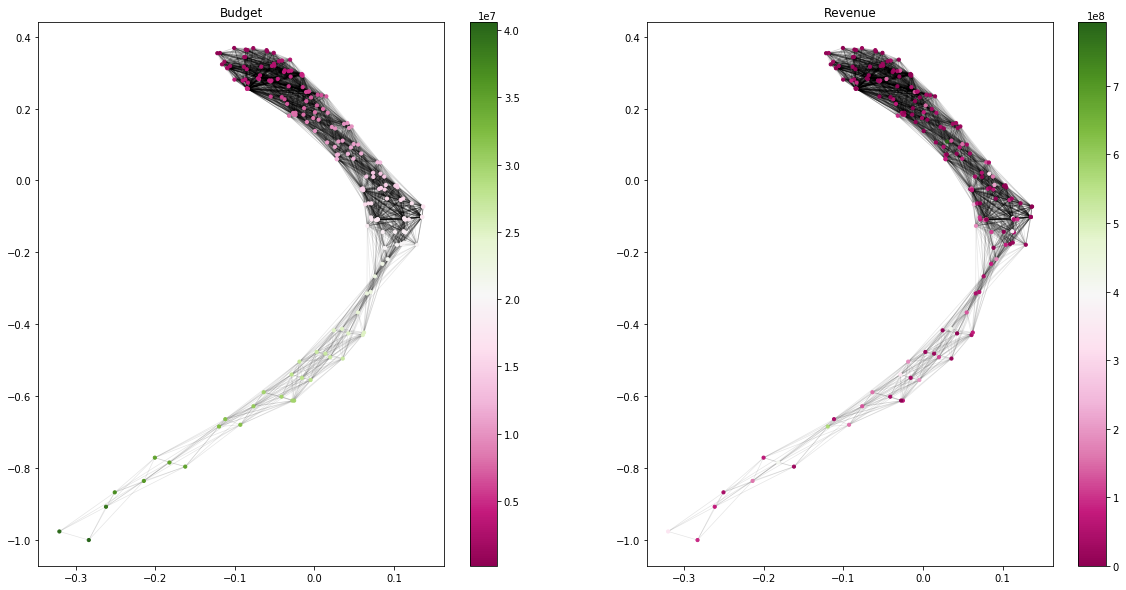

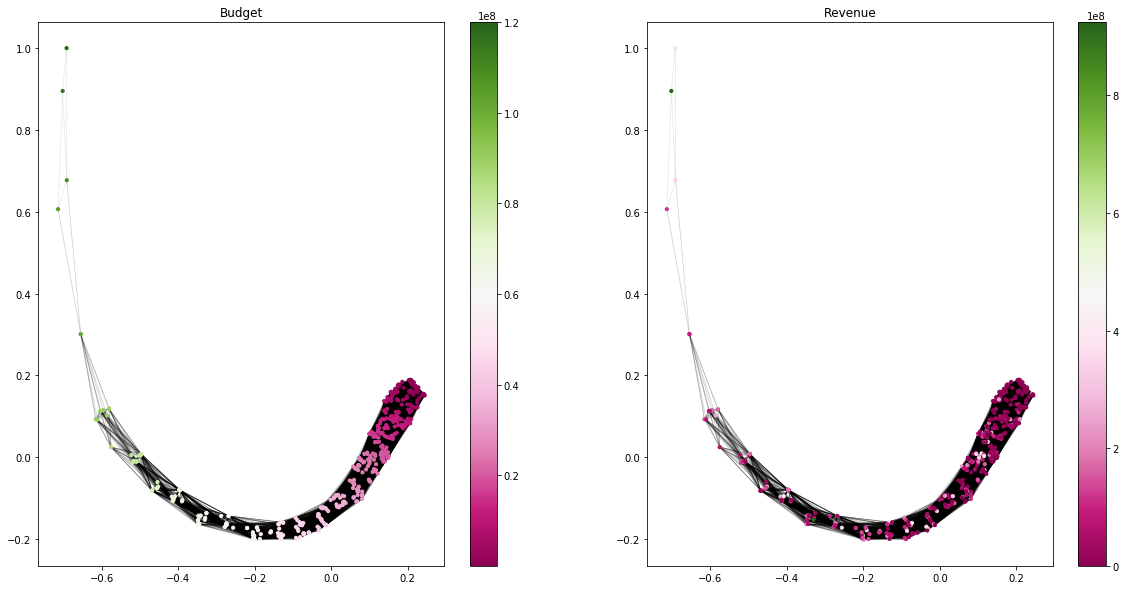

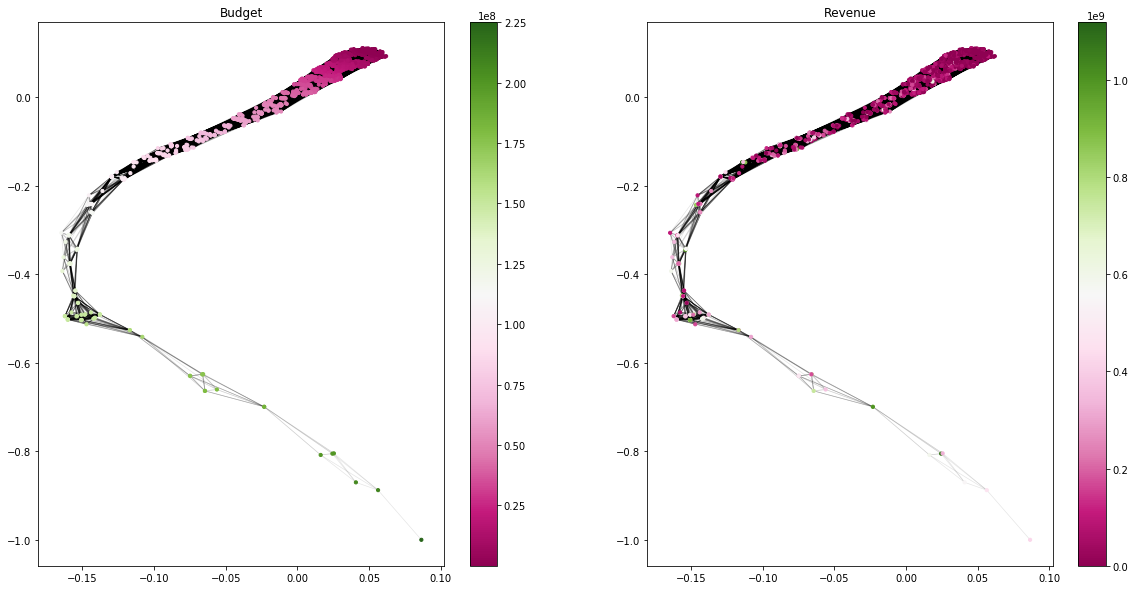

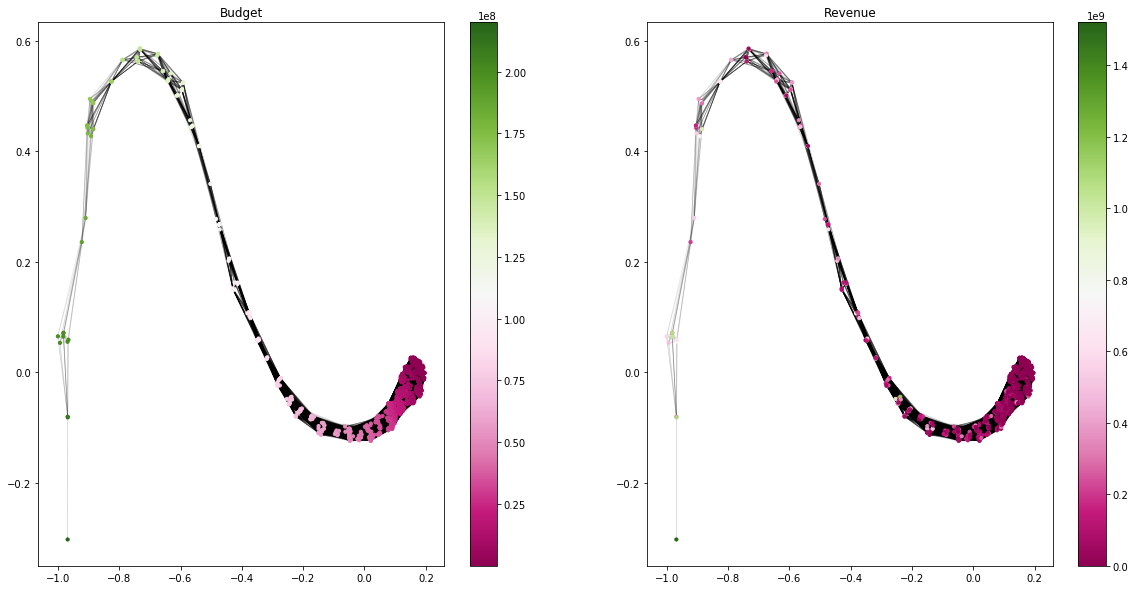

In [8]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue')
    plt.colorbar(im);
        
    i=i+1

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


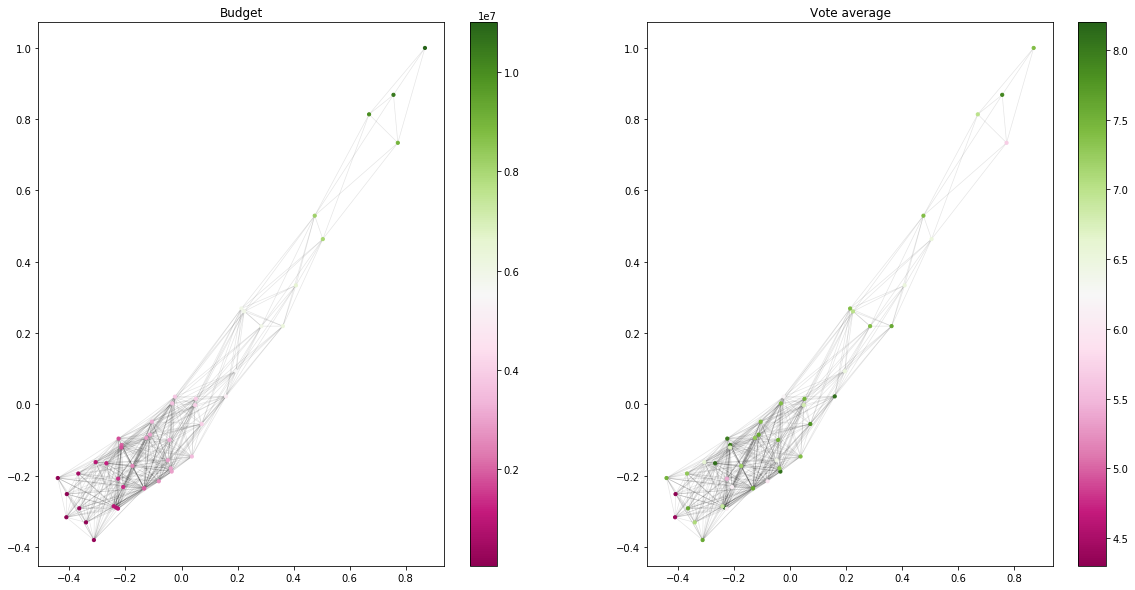

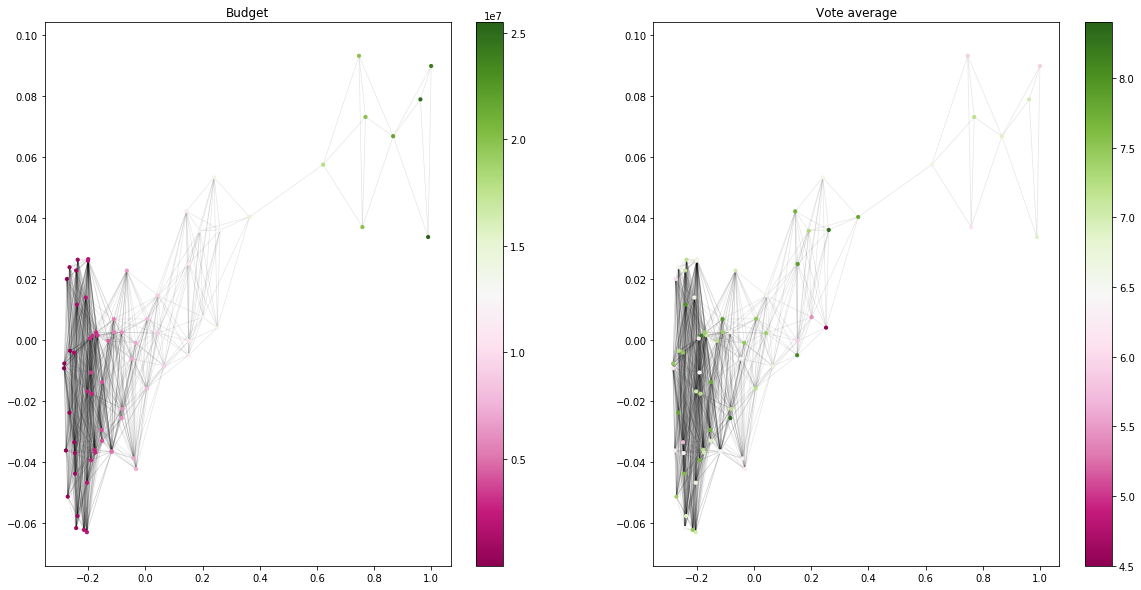

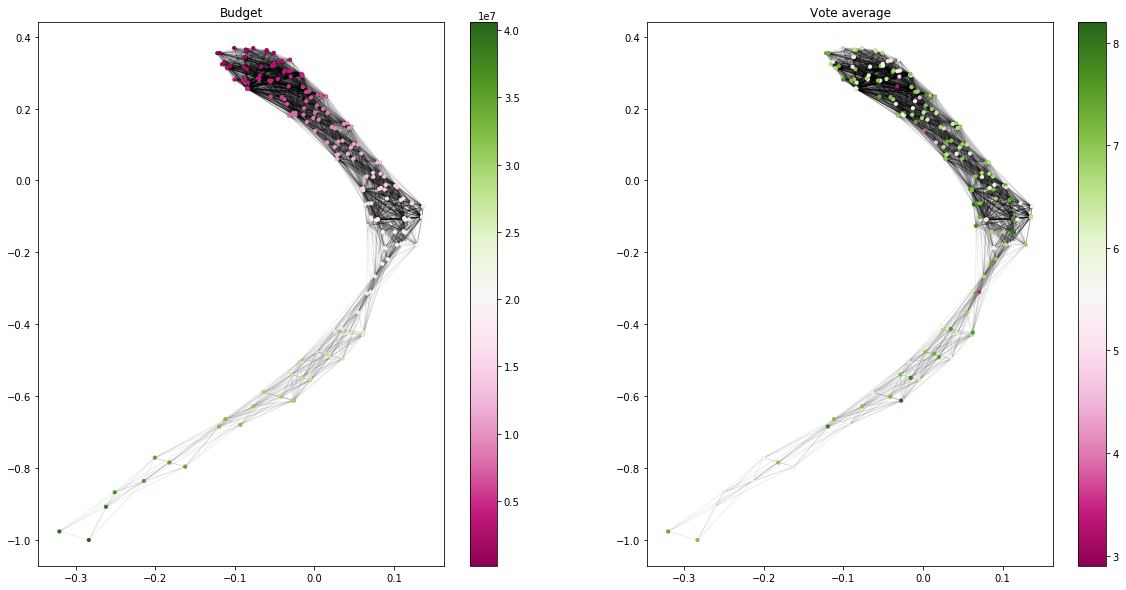

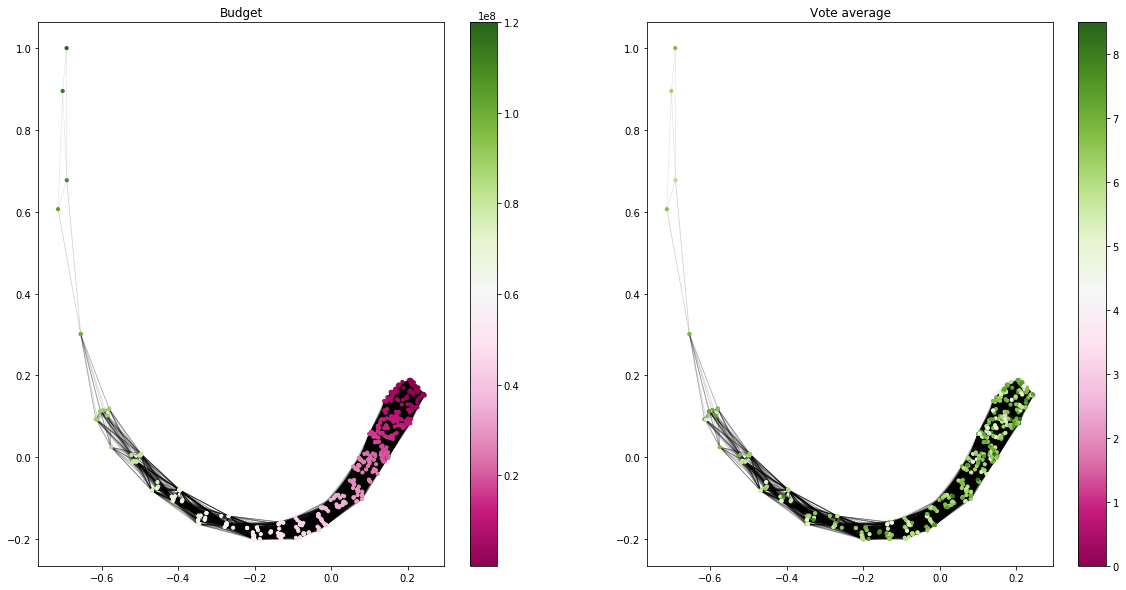

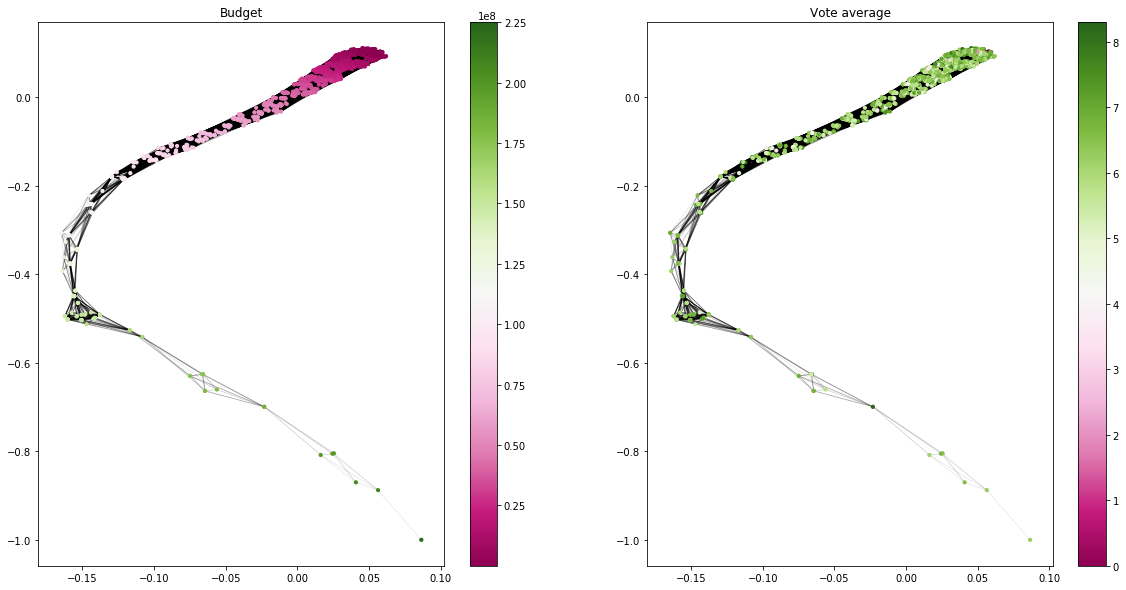

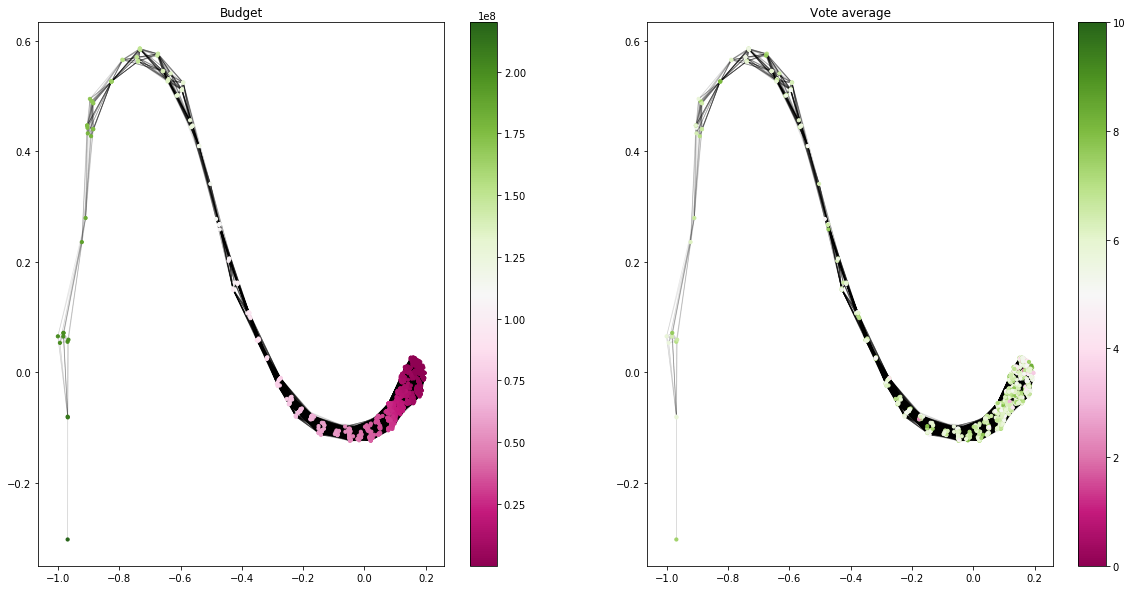

In [9]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1

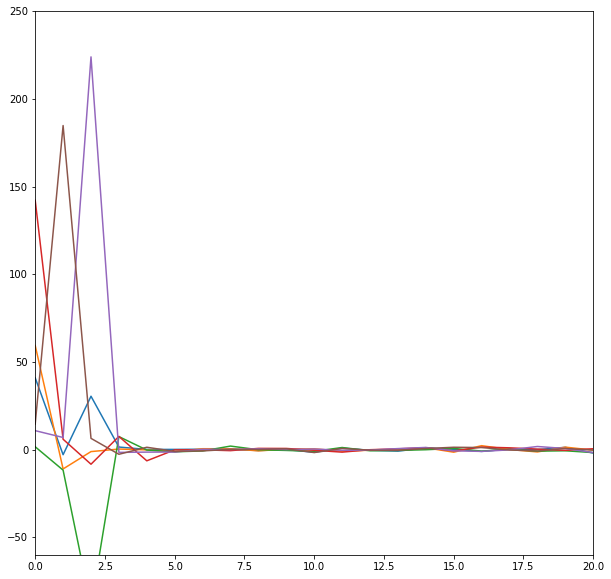

In [10]:
i=0
plt.figure(figsize=(10,10))
plt.axis([0,20,-60,250])
for G in graphsFilteredByYears:
    plt.plot(voteAvrgFtFilteredByYears[i])
    i=i+1


Text(0.5, 1.05, 'adjacency matrix')

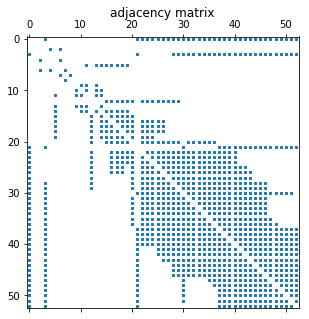

In [11]:
plt.figure(figsize=(5, 5))
plt.spy(adjacenciesFilteredByYears[0], markersize=2)
plt.title('adjacency matrix')